In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Non-parametric Bayes: Gaussian Processes

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

## Building models with Gaussians

It is easy to develop large, parametric models $p(y|\theta)$ for large $\theta$, particularly in a Bayesian context. However, this usually results in having to work with multidimensional integration over $\theta$. 

One approach is to use MCMC; another is to represent your model with Gaussians. Normal distributions are easier to work with.

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

* marginals of multivariate normal distributions are normal

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

* conditionals of multivariate normals are normal

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


In some situations, we want to gain inference about *functions*, rather than about, say, individuals or small vectors of parameters.

A Gaussian process generalizes the multivariate normal to infinite dimension. It is considered a non-parametric approach, despite having an infinite number of parameters.

**Gaussian Process**

> An infinite collection of random variables, any finite subset of which have a Gaussian distribution.

A Gaussian process is a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a squared exponential, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. (*spoiler*: we usually aren't very interested in the mean function!).

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Basic exponential kernel
exponential_kernel = lambda x, y, params: params[0] * \
    np.exp( -0.5 * params[1] * np.sum((x - y)**2) )

We can generate a random sample from a GP with mean function zero and a double exponential covariance function as follows. 

In the context of Gaussian Processes, the covariance matrix is  referred to as the kernel (or Gram) matrix.

In [3]:
# Covariance matrix for MV normal
covariance = lambda kernel, x, y, params: \
    np.array([[kernel(xi, yi, params) for xi in x] for yi in y])

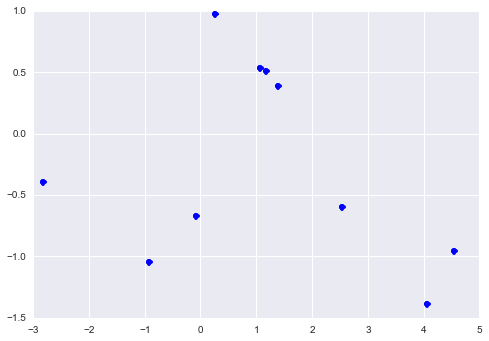

In [4]:
x = np.random.randn(10)*2
theta = [1, 10]
sigma = covariance(exponential_kernel, x, x, theta)
y = np.random.multivariate_normal(np.zeros(len(x)), sigma)
plt.plot(x, y, 'bo')

### Conditional distribution

We can generate sample functions (*realizations*) sequentially, using the conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

This function implements the conditional:

In [5]:
def conditional(x_new, x, y, fcov=exponential_kernel, params=theta):
    B = covariance(fcov, x_new, x, params)
    C = covariance(fcov, x, x, params)
    A = covariance(fcov, x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B).T.dot(y)
    sigma = A - np.linalg.inv(C).dot(B).T.dot(B)
    return mu.squeeze(), sigma.squeeze()

The band plotted below represents the prior mean function, plus and minus one standard deviation.

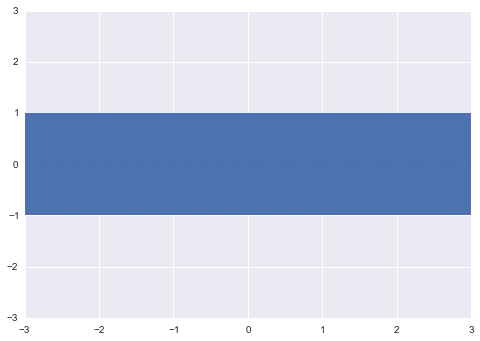

In [6]:
sigma0 = exponential_kernel(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma0, capsize=0)
plt.ylim(-3, 3);

We start by selecting a point at random, then drawing from an *unconditional* Gaussian:

In [7]:
x = [1.]
y = [np.random.normal(scale=sigma0)]
y

[-0.7607861506012358]

We can now calculate the conditional distribution, given the point that we just sampled.

In [8]:
sigma1 = covariance(exponential_kernel, x, x, theta)

In [9]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [10]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_kernel, theta, sigma1, y) 
               for i in x_pred]

Let's plot this to get an idea of what this looks like:

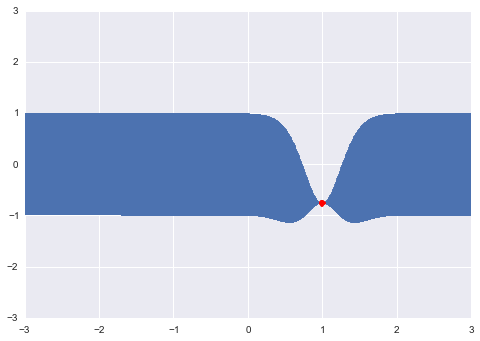

In [11]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Now, we can select a second point, conditional on the first point, using this new distribution. Let's arbitrarily select one at $x=-0.7$

In [12]:
mu2, s2 = conditional([-0.7], x, y)
y2 = np.random.normal(mu2, s2)
y2

0.37195200694374364

In [13]:
x.append(-0.7)
y.append(y2)

We can calculate the conditional distribution again:

In [14]:
sigma2 = covariance(exponential_kernel, x, x, theta)

In [15]:
predictions = [predict(i, x, exponential_kernel, theta, sigma2, y) 
               for i in x_pred]

(-3, 3)

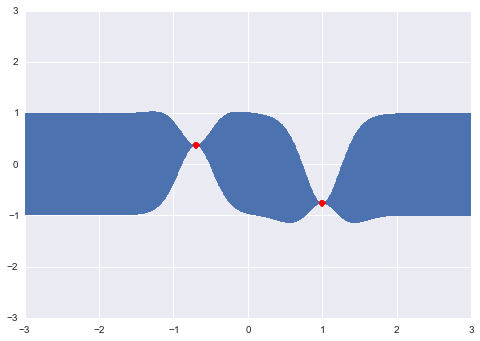

In [16]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3)

Notice how the existing points constrain the selection of subsequent points.

In [17]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 0.61206537,  1.19877915, -0.28605053,  3.24753331,  0.21642368])

In [18]:
x += x_more
y += y_more.tolist()

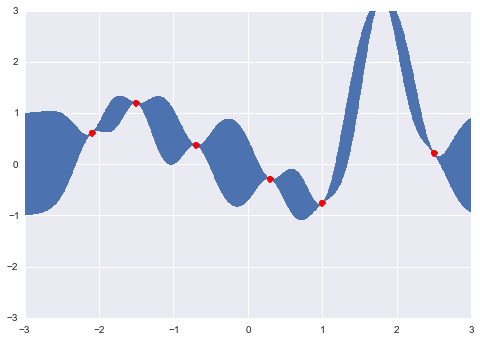

In [19]:
sigma_new = covariance(exponential_kernel, x, x, theta)

predictions = [predict(i, x, exponential_kernel, theta, sigma_new, y) 
               for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

Note that this is exactly equivalent to adding points simultaneously.

We are not restricted to a double-exponential covariance function. Here is a slightly more general function, which includes a constant and linear term, in addition to the exponential.

$$k(x,x\prime) = \theta_1 \exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right) + \theta_3 + \theta_4 x^{\prime} x$$

In [20]:
# Exponential kernel, plus constant and linear terms
exponential_linear_kernel = lambda x, y, params: \
    exponential_kernel(x, y, params[:2]) + params[2] + params[3] * np.dot(x, y)

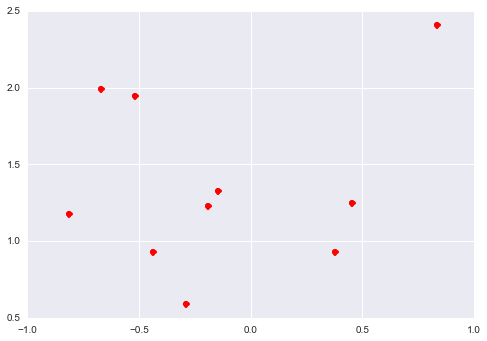

In [21]:
# Parameters for the expanded exponential kernel
theta = 2.0, 50.0, 0.0, 1.0

# Some sample training points.
xvals = np.random.rand(10) * 2 - 1

# Construct the Gram matrix
C = covariance(exponential_linear_kernel, xvals, xvals, theta)

# Sample from the multivariate normal
yvals = np.random.multivariate_normal(np.zeros(len(xvals)), C)

plt.plot(xvals, yvals, "ro")

In [22]:
x_pred = np.linspace(-1, 1, 1000)
predictions = [predict(i, xvals, exponential_linear_kernel, theta, C, yvals) 
               for i in x_pred]

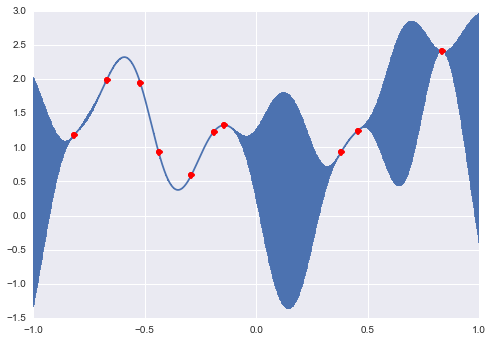

In [23]:
y, sigma = np.transpose(predictions)
plt.errorbar(x_pred, y, yerr=sigma, capsize=0)
plt.plot(xvals, yvals, "ro")

We can use the GP as a prior, and update it using data (rather than random realizations), to obtain a posterior GP that we can use for prediction, conditional on the data.

## Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

GP prior:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

Gaussian likelihood:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

Marginal likelihood:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

These examples, of course, are trivial because they are simply random functions. What we are really interested in is *learning* about an underlying function from information residing in our data. In a parametric setting, we either specify a likelihood, which we then maximize with respect to the parameters, of a full probability model, for which we calculate the posterior in a Bayesian context. Though the integrals associated with posterior distributions are typically intractable for parametric models, they do not pose a problem with Gaussian processes.

## Gaussian process priors

We can treat our zero-mean (or otherwise arbitrary) Gaussian process as a prior for our model. If we are able to use a Gaussian as our data likelihood, then we can construct a Gaussian proceess posterior.

Keeping in mind that a Gaussian process is a distribution over functions, rather than parameters, our likelihood takes the following form:

$$y|p(x),x \sim \mathcal{N}(p(x), \sigma^2I) $$

Here, $\sigma^2$ represents observation error, or noise, and our unknown is a function.

Notice that the GP likelihood conditions on a function; however, we are only interested in the function at locations where we have data!

The corresponding prior is:

$$p(x) \sim \mathcal{GP}(m_0(x), k_0(x,x\prime))$$

Multiplying an infinite normal with another infinite normal yields another infinite normal, our posterior process:

$$p(x)|y \sim \mathcal{GP}(m_{post}, k_{post}(x,x^{\prime}))$$

where

$$\begin{aligned}
m_{post} &= k(x,x^{\prime})^T[k(x,x) + \sigma^2I]^{-1}y \\
k_{post}(x,x^{\prime}) &= k(x^{\prime},x^{\prime}) - k(x,x^{\prime})^T[k(x,x) + \sigma^2I]^{-1}k(x,x^{\prime})
\end{aligned}$$

The posterior predictive distribution for the GP is specified by:

$$\begin{aligned}
m^* &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*,x) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

Though this calculation may seem straightforward, but note that the mean and covariate calculations involve inversions $k(x,x)$, which is a $\mathcal{O}(n^3)$ computation. Thus, Gaussian processes as presented are usually only feasible for data up to a few thousand observations in size.

## Gaussian Processes in PyMC

Along with standard parametric Bayesian models, PyMC 2 includes a module `gp` for fitting non-parametric models using Gaussian processes.

### Mean function

The mean function of a GP can be interpreted as a "prior guess" at the form of the true function. Typically, we use a zero mean function (or some linear function), as we have seen above, but we can choose from a range of alternatives.

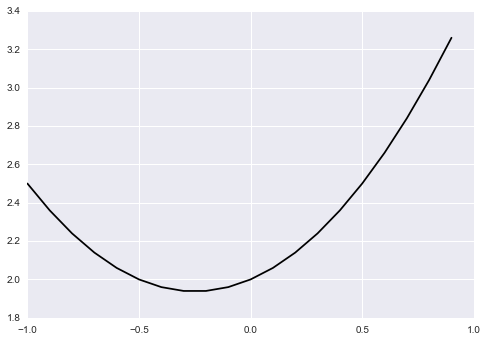

In [24]:
from pymc import gp

# Generate mean
def quadfun(x, a, b, c):
    return (a*x**2 + b*x + c)

M = gp.Mean(quadfun, a=1., b=0.5, c=2.)

x = np.arange(-1,1,0.1)
plt.plot(x, M(x), 'k-')

## Covariance function

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

The Mat&#232;rn class of functions is a flexible choice.

$$k_{Matern}(d) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} d}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} d}{l}\right)$$

The Mat&#232;rn covariance function has three parameters, each of which clearly controls one of three important properties of realizations.

**amplitude** ($\sigma$)

The amplitude parameter (`amp` in PyMC) is a multiplier for realizations from the function that essentially stretches or compresses the y-axis.

**lengthscale of changes** ($l$)

The lengthscale parameter (`scale`) similarly scales realizations on the x-axis. Larger (greater than 1) values make points appear closer together.

**roughness** ($\nu$)

The roughness parameter (`diff_degree`) controls the sharpness of the ridge of the covariance function, which in turn affects the roughness (or smoothness) of realizations.

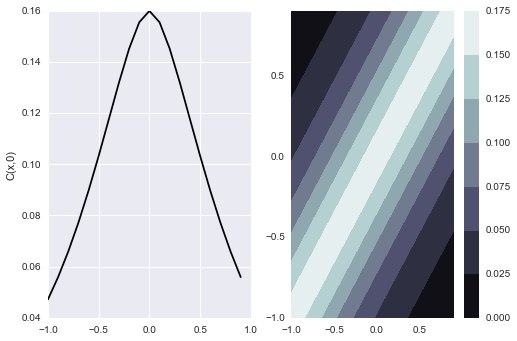

In [25]:
from pymc.gp.cov_funs import matern

C = gp.Covariance(eval_fun=matern.euclidean, diff_degree=1.4, amp=0.4, 
                  scale=1, rank_limit=1000)

plt.subplot(1,2,2)
plt.contourf(x, x, C(x,x).view(np.ndarray), origin='lower', extent=(-1,1,-1,1), 
            cmap=plt.cm.bone)
plt.colorbar()

plt.subplot(1,2,1)
plt.plot(x, C(x,0).view(np.ndarray), 'k-')
plt.ylabel('C(x,0)')

In [26]:
# Returns the diagnonal
C(x)

array([ 0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,
        0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,  0.16,
        0.16,  0.16])

Keep in mind that the covariance functions described above use a single parameter for controlling each of the attributes of the GP realizations. This implies that in a multivariate setting, such a covariance function would force the covariates to be isotropic in their influence on the response. If this is unreasonable, then the covariance function must be generalized to produce an anisotropic GP.

### Drawing realizations from a GP

Since a Gaussian process is a distribution over functions, sampling from it yields functions rather than points. We refer to draws from GPs as *realizations*, which are represented using `Realization` objects in PyMC.

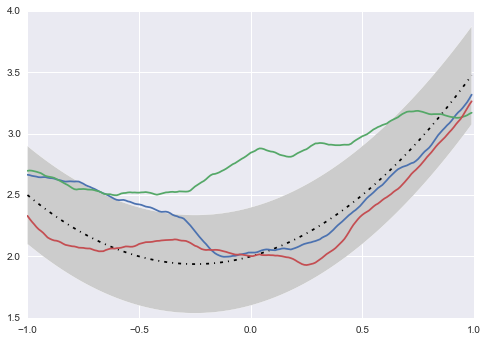

In [27]:
# Generate realizations
f_list = [gp.Realization(M, C) for i in range(3)]

# Plot mean and covariance
x = np.arange(-1,1,0.01)
gp.plot_envelope(M, C, x)

# Add realizations
for f in f_list:
    plt.plot(x, f(x))

Let's use a GP to model observations as coming from a function for which we are highly uncertain. We can model this data as:

$$ \text{data}_i \sim \text{N}(f(o_i), V_i) $$

which assumes only that the observation error is normally distributed. To represent the uncertainty regarding the expected value, we use a Gaussian process prior: 

$$ f \sim \text{GP}(M_o, C_o) $$ 

Combining these yields a posterior for *f* that is also a Gaussian process, with new mean and covariance functions:

$$ f|\text{data} \sim \text{GP}(M, C) $$

In [28]:
M = gp.Mean(quadfun, a=1., b=0.5, c=2.)
C = gp.Covariance(eval_fun=matern.euclidean, diff_degree=1.4, 
                  amp=0.4, scale=1, rank_limit=1000)

obs_x = np.array([-.5, .5])
V = np.array([0.002, 0.002])
data = np.array([3.1, 2.9])

gp.observe(M=M, C=C, obs_mesh=obs_x, obs_V=V, obs_vals=data)

# Generate realizations from posterior
f_list = [gp.Realization(M,C) for i in range(3)]

The function `observe` informs the mean and covariance functions that values on `obs_mesh` with observation variance `V`. Making observations with no error is called `conditioning`. This is useful when, for example, forcing a rate function to be zero when a population's size is zero.

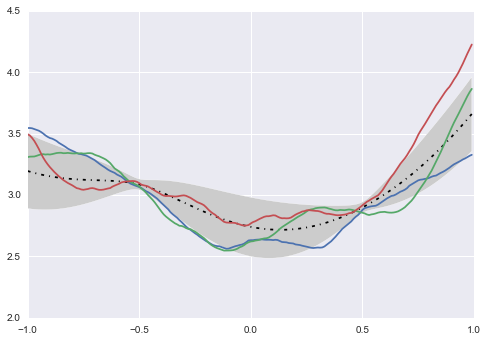

In [29]:
gp.plot_envelope(M, C, mesh=x)
for f in f_list:
    plt.plot(x, f(x))

### Example: Sockeye salmon spawning

![sockeye](./images/sockeye.jpg)

In [30]:
sockeye_data = np.reshape([2986,9,
3424,12.39,
1631,4.5,
784,2.56,
9671,32.62,
2519,8.19,
1520,4.51,
6418,15.21,
10857,35.05,
15044,36.85,
10287,25.68,
16525,52.75,
19172,19.52,
17527,40.98,
11424,26.67,
24043,52.6,
10244,21.62,
30983,56.05,
12037,29.31,
25098,45.4,
11362,18.88,
24375,19.14,
18281,33.77,
14192,20.44,
7527,21.66,
6061,18.22,
15536,42.9,
18080,46.09,
17354,38.82,
17301,42.22,
11486,21.96,
20120,45.05,
10700,13.7,
12867,27.71,], (34,2))

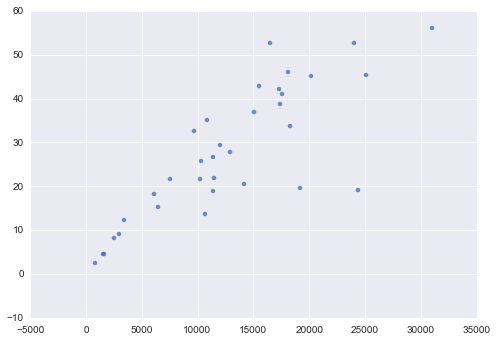

In [43]:
sns.regplot(*sockeye_data.T, fit_reg=False)

In [31]:
abundance = sockeye_data[:,0].ravel()
frye = sockeye_data[:,1].ravel()

# Function for prior mean
line = lambda x, slope: slope * x

M = gp.Mean(line, slope=(frye / abundance).mean())

C = gp.Covariance(matern.euclidean,
            diff_degree=1.4,
            scale=100.*abundance.max(),
            amp=200.*frye.max())

#gp.observe(M, C, obs_mesh=0, obs_vals=0, obs_V=0)

In [32]:
# Observe some data
gp.observe(M, C, obs_mesh=abundance, 
        obs_vals=frye, obs_V=10*frye)

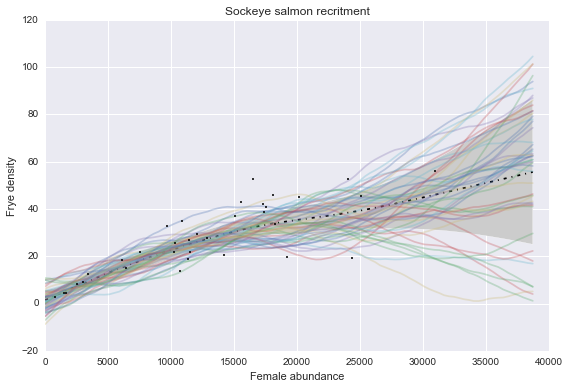

In [33]:
xplot = np.linspace(0,1.25 * abundance.max(),100)

gp.plot_envelope(M, C, xplot)

for i in range(50):
    f = gp.Realization(M, C)
    plt.plot(xplot,f(xplot),alpha=0.3)

plt.plot(abundance, frye, 'k.', markersize=4)
plt.xlabel('Female abundance')
plt.ylabel('Frye density')
plt.title('Sockeye salmon recritment')
plt.tight_layout()

## Gaussian Process Prior and MCMC

The flexibility of Gaussian processes compels us to consider them as functional forms for prior distributions, and to fit them using MCMC. However, since a `GaussianProcess` object is a stochastic whose value is a `Realization` object, we cannot simply endow a it with a `logp` attribute, and so `GaussianProcess` objects cannot be handled by PyMC’s standard MCMC machinery. However, we can evaluate the GP on a `obs_mesh`, which yields a simple multivariate normal random variable that can be handled by PyMC. Thus, the `GPSubmodel` class is a container for `GaussianProcess` objects that performs this step.

In [45]:
from pymc import Gamma, deterministic, observed, MCMC
from pymc import InverseGamma, Uniform, normal_like

class SalmonSampler(MCMC):

    def __init__(self, abundance, frye):

        lfrye = np.log(frye)
        labundance = np.log(abundance)

        rx = labundance.max() - labundance.min()
        ry = lfrye.max() - lfrye.min()


        self.abundance = abundance
        self.frye = frye
        self.lfrye = np.log(frye)
        self.labundance = np.log(abundance)
        self.plot_x = np.linspace(self.abundance.min()*.1,self.abundance.max(),100)

        # The mean function's parameters
        beta_0 = Gamma('beta_0', alpha = np.log(4.5), beta = 1./(10.*(ry/4.)**2))
        beta_1 = Gamma('beta_1', alpha = 1.6 * np.log(1000.) / ry**2, beta = 1.6 * np.log(1000.) / ry**2)

        # The covariance function's parameters
        invtausq = Gamma('invtausq', alpha = 2., beta = 1./(10.*(ry/4.)**2))

        @deterministic
        def amp(invtausq=invtausq):
            """
            Prior amplitude of f.
            """
            return 1./np.sqrt(invtausq)

        scale = InverseGamma('scale' , alpha=2., beta=1./(6. / rx), value=3)
        diff_degree = Uniform('diff_degree', .1, 3, value=1.5)

        @deterministic
        def C(diff_degree=diff_degree, amp=amp, scale=scale):
            """
            The Matern covariance function, observed to be zero at the origin.
            """
            C = gp.Covariance(matern.euclidean, diff_degree=diff_degree, amp=amp, scale=scale)
            return C

        @deterministic
        def M(beta_0 = beta_0, beta_1 = beta_1):
            """
            The mean function is the Cushing stock-recruitment function
            """
            M = gp.Mean(lambda x: beta_0+ x*beta_1)
            return M

        SR = gp.GPSubmodel('SR', M, C, mesh = labundance)

        frye_tau = Gamma('frye_tau', alpha=2., beta=1./(10.*(ry/4.)**2))

        @deterministic
        def frye_V(frye_tau=frye_tau):
            """
            frye_V = 1/(frye_tau)
            """
            return 1./(frye_tau)


        @observed
        def obs_frye(value=lfrye, mu = SR.f_eval, mesh=labundance, tau = frye_tau):
            """
            The log of the frye count.
            """
            return normal_like(value, mu, tau)

        MCMC.__init__(self, locals())
        
        self.use_step_method(gp.GPEvaluationGibbs, SR, frye_V, obs_frye, verbose=0)


    def plot_traces(self):
        for object in [self.beta_0, self.beta_1, self.amp, self.scale, self.diff_degree, self.frye_tau]:
            y=object.trace()
            plt.figure()
            plt.plot(y)
            plt.title(object.__name__)


    def plot_SR(self, n=3):
        f_trace = self.SR.f.trace()
        
        gp.gpplots.plot_GP_envelopes(self.SR.f, self.plot_x, transx=np.log, 
                                     transy=np.exp)

        for i in range(n):
            plt.plot(self.plot_x, np.exp(f_trace[i](np.log(self.plot_x))), 
                     label='draw %i'%i)

        plt.plot(self.abundance, self.frye, 'k.', label='data', markersize=8)
        plt.axis([self.abundance.min()*.1, 
                  self.abundance.max(), 
                  0., 
                  self.frye.max()*2.])

In [46]:
ss = SalmonSampler(abundance, frye)

In [47]:
ss.sample(10000, 5000, verbose=0)

 [-----------------100%-----------------] 10000 of 10000 complete in 38.9 sec

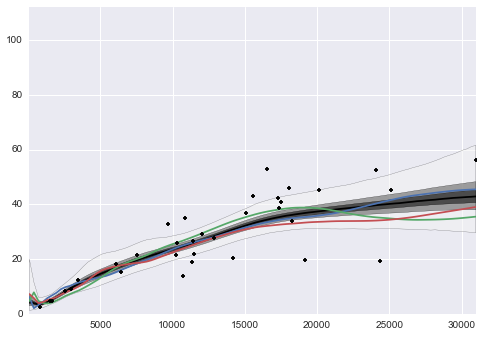

In [48]:
ss.plot_SR()

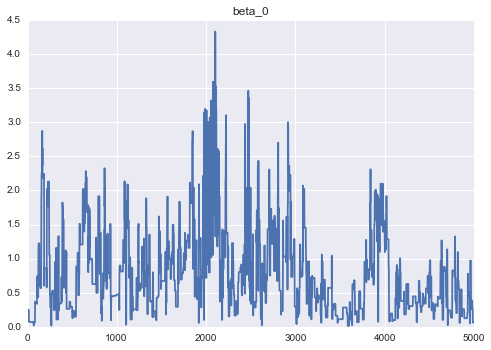

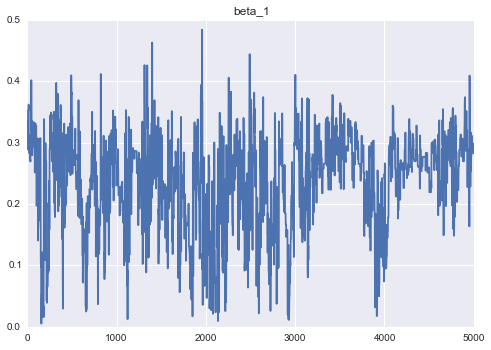

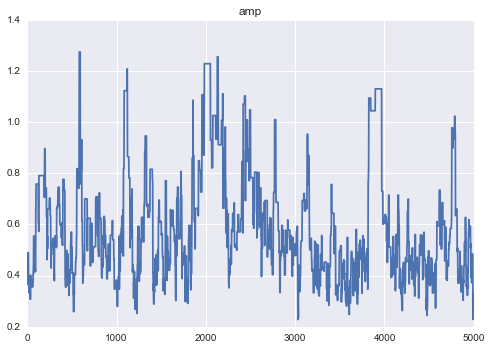

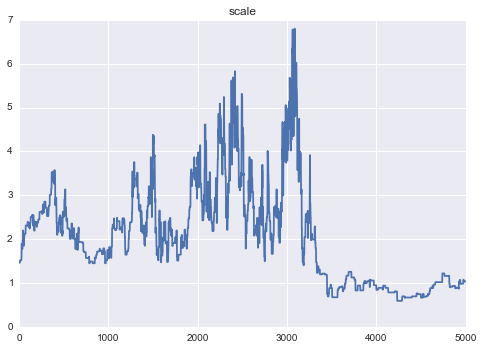

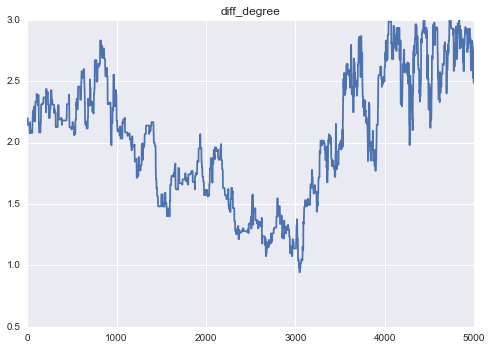

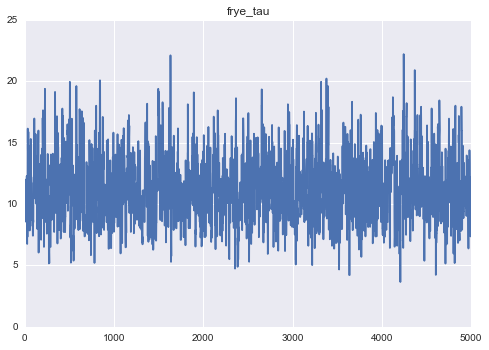

In [49]:
ss.plot_traces()

## Gaussian Processes in `scikit-learn`

`scikit-learn` also provides a robust implementation of Gaussian processes, with the same familiar interface that its other machine learning methods use.

In [50]:
from sklearn.gaussian_process import GaussianProcess

Specification of a `GaussianProcess` model class corresponds closely to that for PyMC. In place of `gp.Mean` and `gp.Covariance`, the scikit-learn implementation takes optional `regr` and `corr` arguments, respectively. These can either be callable functions or one of several built-in options.

The `regr` argument specifies a regression function (i.e. the mean function) returning an array of outputs of the linear regression functional basis. The built-in functions are `constant` (default choice), `linear`, and `quadratic`.

Similarly, the `corr` argument specifies a stationary autocorrelation function for any two points. The built-in correlation models include `absolute_exponential`, `squared_exponential` (default choice), `generalized_exponential`, `cubic`, and `linear`.

Users can optionally specify autocorrelation parameter(s) `theta0`, which can either be scalar, or the size of the number of predictor variables. If arguments `thetaL` and `thetaU` are also provided, then these are taken as the lower and upper bounds on the autocorrelation parameters, with `theta0` the starting "guess" at a MLE of the parameter set.

A `GaussianProcess` can be regularized by providing a `nugget` argument. Mathematically, the value represents the variance of the input values (*e.g.* observation error or other noise).

Thus, the fitting of the regression and autocorrelation functions for the Gaussian process is highly automated in `scikits-learn`.

In [59]:
X = abundance[:, None]
y = frye

G = GaussianProcess(theta0=1e-3, nugget=1e-12)
G.fit(X, y)

GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x11199db70>, normalize=True,
        nugget=array(1e-12), optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x104b1a9b0>,
        regr=<function constant at 0x10fc5ed90>, storage_mode='full',
        theta0=array([[ 0.001]]), thetaL=None, thetaU=None, verbose=False)

Evaluate model over grid.

In [60]:
X_pred = np.linspace(X.min(), X.max())[:, None]

In [61]:
y_pred, MSE = G.predict(X_pred, eval_MSE=True)
sigma = np.sqrt(MSE)

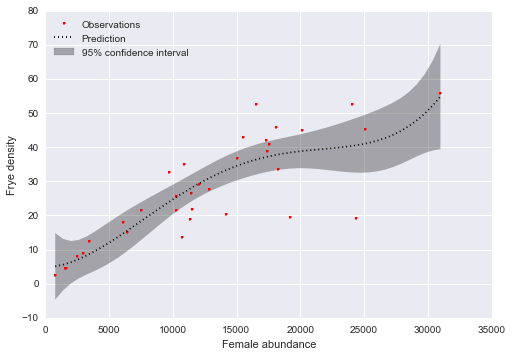

In [62]:
plt.plot(X, y, 'r.', markersize=6, label=u'Observations')
plt.plot(X_pred, y_pred, 'k:', label=u'Prediction')
plt.fill(np.concatenate([X_pred, X_pred[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.3, fc='k', ec='None', label='95% confidence interval')
plt.xlabel('Female abundance')
plt.ylabel('Frye density')
plt.legend(loc='upper left')

The model above was fit using arbitrarily-chosen hyperparameters. Typically, the hyperparameters are tuned to achieve the best model fit, according to selected criteria. As a preview of model building in `scikit-learn`, we can tune our GP by evaluating the model across a grid of plausible parameter values. The best combination will be chosen based on the minimum MSE.

In [63]:
parameter_grid = {'theta0': np.logspace(-7, 0), 'nugget': np.logspace(-5, 3)}

In [64]:
from sklearn.grid_search import GridSearchCV

gp = GaussianProcess()
cv = GridSearchCV(gp, parameter_grid, scoring='mean_squared_error')
cv.fit(X, y);

In [65]:
gp_best = GaussianProcess(**cv.best_params_)
gp_best.fit(X, y)
cv.best_params_

{'nugget': 0.05689866029018293, 'theta0': 0.071968567300115138}

In [66]:
y_pred, MSE = gp_best.predict(X_pred, eval_MSE=True)
sigma = np.sqrt(MSE)

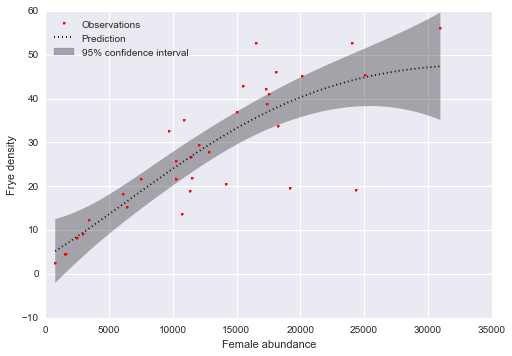

In [67]:
plt.plot(X, y, 'r.', markersize=6, label=u'Observations')
plt.plot(X_pred, y_pred, 'k:', label=u'Prediction')
plt.fill(np.concatenate([X_pred, X_pred[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.3, fc='k', ec='None', label='95% confidence interval')
plt.xlabel('Female abundance')
plt.ylabel('Frye density')
plt.legend(loc='upper left')

## Example: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [68]:
import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

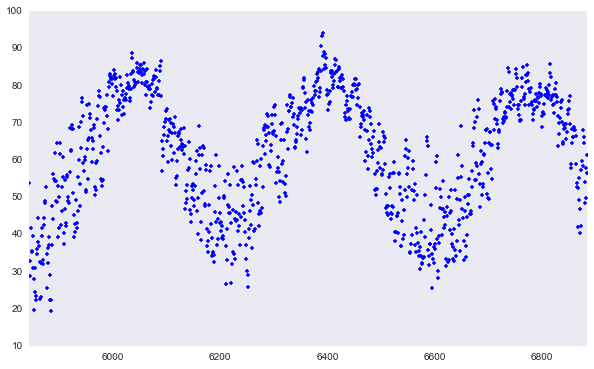

In [69]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [ ]:
# Write your answer here

## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)